# Проект для «Викишоп»

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import re
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import f1_score, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.svm import LinearSVC

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

SEED = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Подготовка

### Загрузка данных

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None


,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


В таблице `toxic_comments` 159292 записи и три столбца: с номером комментария, текстом и отметкой о токсичности. Столбец с номером не нужен - для упорядочивания в таблице есть индексы.

In [3]:
df = df.drop('Unnamed: 0', axis=1)
display(df.tail(3))
print('Дубликаты:', df.duplicated().sum())

,text,toxic
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0
159291,"""\nAnd ... I really don't think you understand...",0


Дубликаты: 0


Удалили столбец с номером. Поискали дубликаты - в таблице их нет.

In [4]:
df['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

Токсичных комментариев почти в 10 раз меньше, чем обычных. Модель обучится лучше, когда классы будут сбалансированы. Это можно сделать несколькими способами: при обучении придать больший вес для малочисленного класса, или уравнять количество комментариев разных классов.

### Очистка текстов

Выберем несколько комментариев для разбора:

In [5]:
for n in [1, 5, 12, 42, 1354]:
    print('\n', df['text'][n], '\n _______________________')


 D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC) 
 _______________________

 "

Congratulations from me as well, use the tools well.  · talk " 
 _______________________

 Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings... 
 _______________________

 You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your 

В текстах встречаются ссылки, разные символы, уточнения в скобках, некоторые тексты имеют заголовки. Текст в скобках и в заголовках нужно оставить, а ссылки удалить, ведь в них нет полезной информации о комментарии. Также в текстах есть слова, которые не несут информации о комментарии, вроде местоимений, предлогов и связующих слов. Напишем функцию, которая уберет ссылки, одиночные буквы и стоп-слова, и применим ее:

In [6]:
stopwords = list(nltk_stopwords.words('english'))

def clear_text(text):
    return ' '.join(filter(lambda s: s not in stopwords, # убираем стоп-слова
                        re.sub(r'\b\w\b', ' ',  # убираем отдельные буквы
                        re.sub(r'[^a-zA-Z ]', ' ',  # удаляем цифры и прочие символы
                        re.sub(r'\w+:\w*/\S+', ' ', text))) # удаляем ссылки
                        .lower().split()
                    ))

tqdm.pandas(position=0)
df['re_text'] = df['text'].progress_apply(clear_text);
df.head()

100%|████████████████████████████████████████████████████████████████████████| 159292/159292 [00:21<00:00, 7401.11it/s]


,text,toxic,re_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww matches background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestions improvement wondered sec...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


Дальше все слова нужно привести к начальной форме - в текстах, конечно же, используются слова в разных формах, но эффективнее будет обучать модель на одной форме, вместо нескольких разных. Проведем лемматизацию:

In [7]:
nlp = spacy.load("en_core_web_sm")

def lemmatize(text):
    text = nlp(text)
    return ' '.join([token.lemma_ for token in text])

tqdm.pandas(position=0)
df['lemm_text'] = df['re_text'].progress_apply(lemmatize);
df.head()

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [24:35<00:00, 107.97it/s]


,text,toxic,re_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...,explanation edit make username hardcore metall...
1,D'aww! He matches this background colour I'm s...,0,aww matches background colour seemingly stuck ...,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestions improvement wondered sec...,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page,sir hero chance remember page


### Анализ токсичности

Проведем небольшой анализ комментариев.

Какие слова чаще всего используются в нейтральных и негативных комментариях?

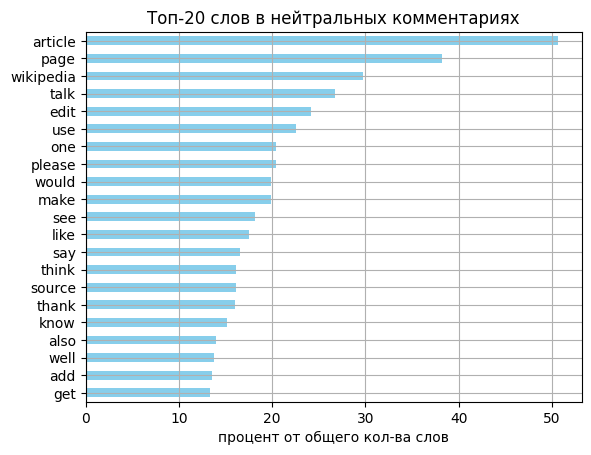

In [8]:
oks = pd.Series(' '.join(df['lemm_text'][df['toxic'] == 0]).split()).value_counts()
oks_stats =  oks / oks.shape[0] * 100
oks_stats[:21].sort_values().plot(kind='barh', grid=True, color='skyblue',
                                  title='Топ-20 слов в нейтральных комментариях',
                                  xlabel='процент от общего кол-ва слов');

В топ-20 самых употребляемых слов в нейтральных комментариях входят слова вроде "страница", "статья", "говорить", "знать", "источник". В таких комментариях, видимо, идет обсуждение материала и правок страниц. Чаще всего встречается слово "article" - оно составляет 21% от всех слов во всех комментариях в данном датасете.

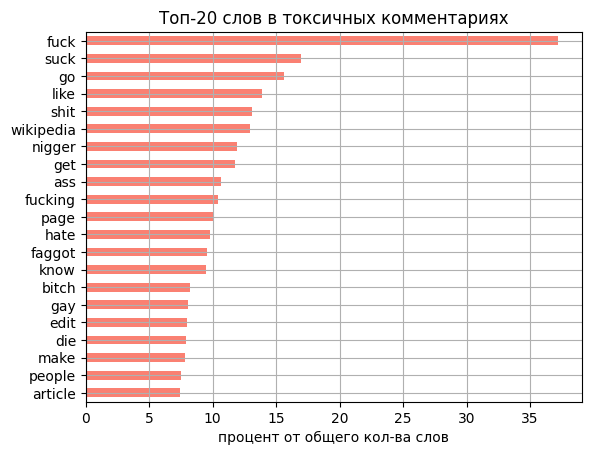

In [9]:
toxics = pd.Series(' '.join(df['lemm_text'][df['toxic'] == 1]).split()).value_counts()
toxic_stats =  toxics / toxics.shape[0] * 100
toxic_stats[:21].sort_values().plot(kind='barh', grid=True, color='salmon',
                                    title='Топ-20 слов в токсичных комментариях',
                                    xlabel='процент от общего кол-ва слов');

Топ-20 самых употребляемых слов в токсичных комментариях почти на половину состоит из обсценной лексики. 37% всех слов занимает слово "fuck" - можно предположить, что это самая популярная нецензурная брань среди англоговорящих.

Появляется еще один вопрос: есть ли в позитивных комментариях слова, встречающиеся в негативных?

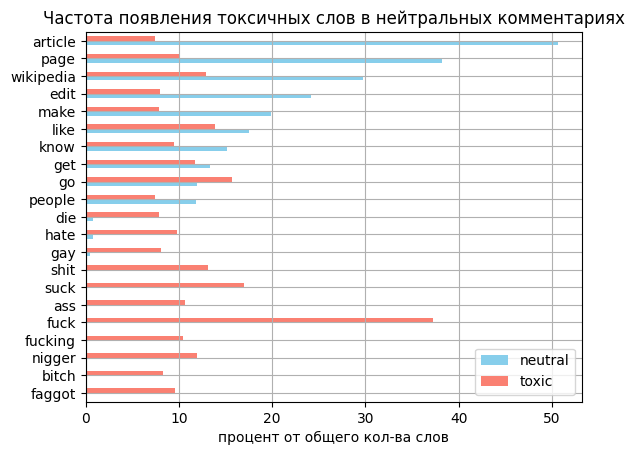

In [10]:
okwords = ' '.join(df['lemm_text'][df['toxic'] == 0]).split()

top = pd.Series(filter(lambda x: x in toxics.index.values[:21], okwords)).value_counts().sort_values()
toxictop = pd.DataFrame(data=(top / oks.shape[0] * 100, toxics[:21] / toxics.shape[0] * 100),
                        index=['neutral', 'toxic']).T.fillna(0).sort_values(by='neutral', ascending=True)
toxictop.plot(kind='barh', grid=True, color=['skyblue', 'salmon'],
              title='Частота появления токсичных слов в нейтральных комментариях',
              xlabel='процент от общего кол-ва слов');

В позитивных комментариях встречаются нецензурные слова, но все они вместе взятые составляют менее 1% от всех слов. На основе этого можно сделать вывод, что если в комментарии есть брань, то скорее всего он токсичный.

И последний вопрос: отличается ли количество слов в обычных и негативных комментариях?

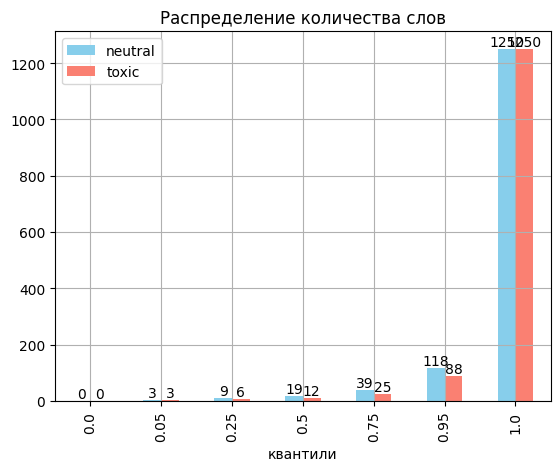

In [11]:
def word_count(text):
    return len(text.split())
    
ax = pd.DataFrame([df['lemm_text'][(df['toxic'] == 0)].apply(word_count).quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1]),
                  df['lemm_text'][(df['toxic'] == 1)].apply(word_count).quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])],
                  index=['neutral', 'toxic']).T.plot(kind='bar', grid=True, color=['skyblue', 'salmon'],
                                                     title='Распределение количества слов', xlabel='квантили')
for container in ax.containers:
    ax.bar_label(container)

Обычно в токсичных комментариях меньше слов - в нейтральных в среднем по 19 слов, а в токсичных - по 12. Сейчас мы считаем только слова "по делу" - может, если бы мы считали также стоп-слова, в негативных было бы больше слов. Почти все комментарии укладываются в 120 слов, только 5% превышают это количество. Максимальное количество слов - 935 для нейтральных и 1250 для токсичных.

Также видно, что минимальное количество слов в комментариях равно 0. Видимо, после очистки в некоторых текстах не осталось ни слова.

In [12]:
df[df['lemm_text'] == '']

,text,toxic,re_text,lemm_text
2091,"No, it doesn´t.80.228.65.162",0,,
2400,"Here, here and here.",0,,
3983,From here\n\nFrom here 160.80.2.8,0,,
4475,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...,0,,
6053,n i g g e r f a g g o t,1,,
...,...,...,...,...
152543,SAME FOR THIS 166.137.240.20,0,,
153041,which is OVER 9000 OVER 9000 OVER 9000 OVER 90...,0,,
153342,http://en.wikipedia.org/w/index.php?title=Cras...,0,,
154588,O.K. (t/c//WP:CHICAGO/WP:LOTM),0,,


Это оказались комментарии, либо целиком состоящие из стоп-слов, цифр, символов и ссылок, либо те, в которых комментаторы проявили креативность и написали слова побуквенно через пробел или точку. Автоматически проверять такие комментарии будет проблематично, если не невозможно.       
В этой выборке пустых текстов оказалось не так много, всего 16 штук. Большого влияния они на обучение не окажут, но лучше будет их удалить:

In [13]:
df = df.drop(df[df['lemm_text'] == ''].index).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159201 entries, 0 to 159200
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       159201 non-null  object
 1   toxic      159201 non-null  int64 
 2   re_text    159201 non-null  object
 3   lemm_text  159201 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.9+ MB


## Обучение

Данные почти готовы, осталось разделить их на выборки и векторизировать - выбранные для обучения модели не будут работать с текстами напрямую.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['lemm_text'], df['toxic'],
                                                    shuffle=True, stratify=df['toxic'], random_state=SEED)

Создадим векторизатор и список для результатов и приступим к обучению.

In [15]:
tf_idf = TfidfVectorizer()
scores = []

### Logistic Regression

Первая модель - логистическая регрессия. Метрикой качества будет F1-мера - она покажет, как часто и точно модель находит положительный класс.      
Соберем пайплайн из векторизатора и самой модели, чтобы провести кросс-валидацию:

In [31]:
%%time
imb_pipe = make_pipeline(tf_idf, SMOTE(random_state=SEED), 
                         LogisticRegression(solver='liblinear', max_iter=500, random_state=SEED))
cross_validate(imb_pipe, X=X_train, y=y_train, scoring='f1', cv=3)['test_score'].mean()

CPU times: total: 1min 15s
Wall time: 21.8 s


0.7694383377927144

Базовая модель показывает F1 равную 0.769. Подберем гиперпараметры:

In [17]:
%%time
params = {'logisticregression__penalty': ['l1', 'l2'],
          'logisticregression__C': [1, 2, 3, 5, 8, 13]}

grid_log = GridSearchCV(imb_pipe, params, scoring='f1', cv=3, verbose=1)
grid_log.fit(X_train, y_train);

Fitting 3 folds for each of 12 candidates, totalling 36 fits
CPU times: total: 15min 41s
Wall time: 5min 5s


In [18]:
def print_grid(grid, name):
    print(grid.best_score_)
    print(grid.best_params_)
    scores.append([name, grid.best_score_,\
                   grid.cv_results_['mean_fit_time'][grid.best_index_]])

print_grid(grid_log, 'LogisticRegression')

0.7759212447011032
{'logisticregression__C': 3, 'logisticregression__penalty': 'l2'}


С оптимальными гиперпараметрами модель показывает результат слегка лучше - F1 теперь равна 0.775.

### SGDClassifier

Следующая модель - классификатор, обученный градиентным спуском.

In [33]:
%%time
imb_pipe = make_pipeline(tf_idf, SMOTE(random_state=SEED), 
                         SGDClassifier(loss='modified_huber', max_iter=500, random_state=SEED))
cross_validate(imb_pipe, X=X_train, y=y_train, scoring='f1', cv=3)['test_score'].mean()

CPU times: total: 1min 12s
Wall time: 20.4 s


0.7710107912768468

In [20]:
%%time
params = {'sgdclassifier__penalty': ['l1', 'l2'],
          'sgdclassifier__alpha': [0.01, 0.005, 0.001, 0.0005, 0.0001]}

grid_sgd = GridSearchCV(imb_pipe, params, scoring='f1', cv=3, verbose=1)
grid_sgd.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: total: 12min 50s
Wall time: 3min 21s


In [21]:
print_grid(grid_sgd, 'SGDClassifier')

0.7710107912768468
{'sgdclassifier__alpha': 0.0001, 'sgdclassifier__penalty': 'l2'}


F1 после подбора гиперпараметров равна 0.771, что немного хуже предыдущей модели.

### Perceptron

Третья модель - перцептрон. Это линейный классификатор хорошо подходит для обучения на датасете с большим количеством нулей в данных.

In [34]:
%%time
imb_pipe = make_pipeline(tf_idf, SMOTE(random_state=SEED), 
                         Perceptron(random_state=SEED))
cross_validate(imb_pipe, X=X_train, y=y_train, scoring='f1', cv=3)['test_score'].mean()

CPU times: total: 1min 11s
Wall time: 19.3 s


0.7276855701496107

In [23]:
%%time
params = {'perceptron__penalty': ['l1', 'l2', None],
          'perceptron__alpha': [0.01, 0.001, 0.0001, 0.00001]}

grid_tron = GridSearchCV(imb_pipe, params, scoring='f1', cv=3, verbose=1)
grid_tron.fit(X_train, y_train);

Fitting 3 folds for each of 12 candidates, totalling 36 fits
CPU times: total: 15min 15s
Wall time: 3min 58s


In [24]:
print_grid(grid_tron, 'Perceptron')

0.7276855701496107
{'perceptron__alpha': 0.01, 'perceptron__penalty': None}


Модель показывает лучший результат со стандартными параметрами - F1 равна 0.728.

### LinearSVC

Последняя модель - SVM классификатор. Также хорошо подходит для обучения на датасете с большим количеством нулей, плюс хорошо справляется и с маленькими и с большими наборами данных.

In [32]:
%%time
imb_pipe = make_pipeline(tf_idf, SMOTE(random_state=SEED), 
                         LinearSVC(dual='auto', random_state=SEED))
cross_validate(imb_pipe, X=X_train, y=y_train, scoring='f1', cv=3)['test_score'].mean()

CPU times: total: 1min 15s
Wall time: 22.7 s


0.7640017830621071

In [26]:
%%time
params = {'linearsvc__penalty': ['l1', 'l2'],
          'linearsvc__C': [1, 2, 3, 5, 8, 13]}

grid_svc = GridSearchCV(imb_pipe, params, scoring='f1', cv=3, verbose=1)
grid_svc.fit(X_train, y_train);

Fitting 3 folds for each of 12 candidates, totalling 36 fits
CPU times: total: 18min 53s
Wall time: 8min 59s


In [27]:
print_grid(grid_svc, 'LinearSVC')

0.7640017830621071
{'linearsvc__C': 1, 'linearsvc__penalty': 'l2'}


Снова лучший результат со стандартными параметрами - F1 равна 0.764.

### Тест

В таблице ниже собраны результаты обучения всех моделей.

In [29]:
pd.DataFrame(scores, columns=['model', 'F1', 'fit time']).sort_values(by='F1').style.format(precision=3)

,model,F1,fit time
2,Perceptron,0.728,5.530
3,LinearSVC,0.764,6.941
1,SGDClassifier,0.771,5.518
0,LogisticRegression,0.776,6.719


Качество моделей отличается не сильно - перцептрон немного отстает, но у остальных F1 очень близка. LogisticRegression показала лучший результат - 0.776, SGD отстал от нее всего на 0.005.

Протестируем лучшую модель.

F1-мера: 0.772


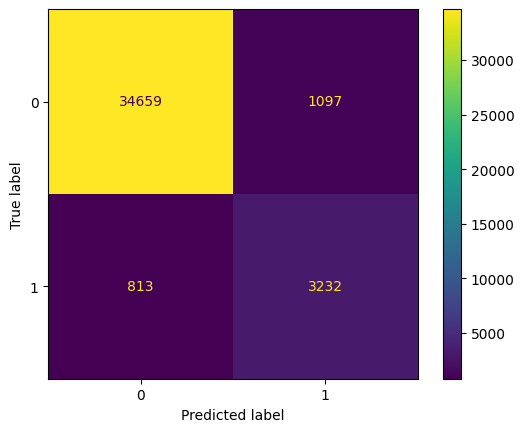

In [30]:
print('F1-мера: %.3f' % f1_score(y_test, grid_log.best_estimator_.predict(X_test)))
ConfusionMatrixDisplay.from_estimator(grid_log.best_estimator_, X_test, y_test);

Качество на тестовой выборке сильно не упало - F1 равна 0.772.

## Выводы

Модель, показавшая лучшие результаты - логгистическая регрессия. Метрика качества F1 у этой модели равна 0.772. Она правильно определила 96.9% положительных комментариев и 79.9% негативных. То, что модель научилась лучше определять нулевой класс не плохо - безобидные комментарии будут реже отправляться на модерацию. А негативные комментарии, пропущенные фильтром, можно "выловить" позднее, если добавить фунцию "пожаловаться на комментарий".

Из анализа комментариев выяснилось, что в токсичных очень часто встречаются нецензурные слова: если в комментарии присутствует брань, то с большой вероятностью он является негативным. При этом в нейтральных комментариях также встречаются негативные слова, но редко - меньше 1% от общего количества слов. Так что наличие нецензурных слов не делает комментарий токсичным автоматически, также как и их отсутствие не делает его положительным. На положительность комментария могут указывать слова вроде "страница", "источник", "знать", "менять" и другие, относящиеся к обсуждению правок и информации. Если их нет в тексте, это может говорить о том, что комментатор пишет "не по теме" или даже перешел на личности, что не очень положительно.      
Также комментарии немного различаются по длине - если считать леммы слов и исключать слова, не несущие смысла (вроде местоимений, предлогов, частиц и вспомогательных глаголов), то нейтральные в среднем состоят из 19 слов, а токсичные из 12.